# Model - Mixed Adult and Pediatric Data

Import all needed in this notebook

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoImageProcessor, ResNetForImageClassification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split, ConcatDataset, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import torch.nn.functional as F

## Model Creation

Create custom model

In [2]:
class CustomCNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 28 * 28, 512) 
        self.fc2 = nn.Linear(512, 256)  
        self.fc3 = nn.Linear(256, num_classes)
        
        self.dropout = nn.Dropout(p=0.5) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 28 * 28)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

num_classes = 2
custom_model = CustomCNNModel(num_classes=num_classes)

In [3]:
# for name, param in custom_model.named_parameters():
#     if "conv2" in name: 
#         param.requires_grad = False
#     else:
#         param.requires_grad = True

Print the structure of the model

In [4]:
print(custom_model)

CustomCNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Print frozen and trainable parameters of model

In [5]:
for name, param in custom_model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

conv1.weight: Trainable
conv1.bias: Trainable
conv2.weight: Trainable
conv2.bias: Trainable
conv3.weight: Trainable
conv3.bias: Trainable
fc1.weight: Trainable
fc1.bias: Trainable
fc2.weight: Trainable
fc2.bias: Trainable
fc3.weight: Trainable
fc3.bias: Trainable


## Dataset Retrieval

Retrieve dataset and compute X (data images in tensor format) and y (binary encoded label)

In [6]:
# with zipfile.ZipFile("preprocessed_medium.zip", 'r') as zip_ref:
#     zip_ref.extractall("")

In [7]:
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

adult_dataset = datasets.ImageFolder(root="data", transform=transform)
pediatric_dataset = datasets.ImageFolder(root="preprocessed_medium", transform=transform)

class_indices = {class_name: [] for class_name in pediatric_dataset.classes}
for idx, (image, label) in enumerate(pediatric_dataset):
    class_indices[pediatric_dataset.classes[label]].append(idx)

train_indices = []
test_indices = []

for class_name in pediatric_dataset.classes:
    indices = class_indices[class_name]
    train_indices.extend(indices[:int(len(indices)*.25)])
    test_indices.extend(indices[int(len(indices)*.25):])

pediatric_train_dataset = Subset(pediatric_dataset, train_indices)
pediatric_test_dataset = Subset(pediatric_dataset, test_indices)

combined_train_dataset = ConcatDataset([adult_dataset, pediatric_train_dataset])

In [8]:
print(f"Combined train dataset size: {len(combined_train_dataset)}")
print(f"Pediatric test dataset size: {len(pediatric_test_dataset)}")

Combined train dataset size: 2746
Pediatric test dataset size: 300


In [9]:
def create_dynamic_sampler(epoch, total_epochs, adult_len, pediatric_len):
    alpha = epoch / total_epochs
    adult_weight = max(0.2, 1 - alpha)  # starts high, decreases
    pediatric_weight = min(1.0, alpha + 0.5)  # starts low, increases
    weights = ([adult_weight] * adult_len) + ([pediatric_weight] * pediatric_len)
    return WeightedRandomSampler(weights, len(weights))

num_epochs = 35
sampler = create_dynamic_sampler(0, num_epochs, len(adult_dataset), len(pediatric_train_dataset))
train_loader = DataLoader(combined_train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(pediatric_test_dataset, batch_size=32, shuffle=True)

for batch in train_loader:
    X_batch, y_batch = batch
    print(f"Batch X shape: {X_batch.shape}, batch y shape: {y_batch.shape}")
    break

Batch X shape: torch.Size([32, 3, 224, 224]), batch y shape: torch.Size([32])


## Model Training And Evaluation

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [11]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    print(f"Device using for training: {device}")
    model = model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(train_loader, unit="batch", desc=f"Epoch [{epoch+1}/{num_epochs}]") as tbar:
            for inputs, labels in tbar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, train_accuracies, test_losses, test_accuracies


def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_losses = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = sum(test_losses) / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=5e-5, weight_decay=5e-3)

scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
train_losses, train_accuracies, test_losses, test_accuracies = train_model(custom_model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs)

Device using for training: cuda


Epoch [1/35]: 100%|██████████| 86/86 [00:16<00:00,  5.27batch/s]


Epoch [1/35], Train Loss: 0.6843, Train Accuracy: 55.94%, Test Loss: 0.6683, Test Accuracy: 56.33%


Epoch [2/35]: 100%|██████████| 86/86 [00:14<00:00,  5.91batch/s]


Epoch [2/35], Train Loss: 0.6463, Train Accuracy: 63.36%, Test Loss: 0.6938, Test Accuracy: 54.33%


Epoch [3/35]: 100%|██████████| 86/86 [00:14<00:00,  5.91batch/s]


Epoch [3/35], Train Loss: 0.6298, Train Accuracy: 66.24%, Test Loss: 0.6906, Test Accuracy: 55.00%


Epoch [4/35]: 100%|██████████| 86/86 [00:14<00:00,  5.94batch/s]


Epoch [4/35], Train Loss: 0.6218, Train Accuracy: 67.26%, Test Loss: 0.6483, Test Accuracy: 56.67%


Epoch [5/35]: 100%|██████████| 86/86 [00:14<00:00,  6.05batch/s]


Epoch [5/35], Train Loss: 0.6019, Train Accuracy: 68.28%, Test Loss: 0.6582, Test Accuracy: 55.00%


Epoch [6/35]: 100%|██████████| 86/86 [00:14<00:00,  5.98batch/s]


Epoch [6/35], Train Loss: 0.6077, Train Accuracy: 67.48%, Test Loss: 0.7566, Test Accuracy: 53.00%


Epoch [7/35]: 100%|██████████| 86/86 [00:14<00:00,  6.06batch/s]


Epoch [7/35], Train Loss: 0.5851, Train Accuracy: 69.74%, Test Loss: 0.6355, Test Accuracy: 61.00%


Epoch [8/35]: 100%|██████████| 86/86 [00:14<00:00,  5.82batch/s]


Epoch [8/35], Train Loss: 0.5961, Train Accuracy: 69.26%, Test Loss: 0.6479, Test Accuracy: 57.67%


Epoch [9/35]: 100%|██████████| 86/86 [00:14<00:00,  5.95batch/s]


Epoch [9/35], Train Loss: 0.5748, Train Accuracy: 70.87%, Test Loss: 0.6914, Test Accuracy: 55.33%


Epoch [10/35]: 100%|██████████| 86/86 [00:14<00:00,  6.05batch/s]


Epoch [10/35], Train Loss: 0.5818, Train Accuracy: 69.99%, Test Loss: 0.6197, Test Accuracy: 64.33%


Epoch [11/35]: 100%|██████████| 86/86 [00:14<00:00,  6.11batch/s]


Epoch [11/35], Train Loss: 0.5697, Train Accuracy: 71.19%, Test Loss: 0.6685, Test Accuracy: 61.67%


Epoch [12/35]: 100%|██████████| 86/86 [00:13<00:00,  6.15batch/s]


Epoch [12/35], Train Loss: 0.5714, Train Accuracy: 70.65%, Test Loss: 0.5902, Test Accuracy: 66.33%


Epoch [13/35]: 100%|██████████| 86/86 [00:14<00:00,  6.08batch/s]


Epoch [13/35], Train Loss: 0.5559, Train Accuracy: 71.45%, Test Loss: 0.6792, Test Accuracy: 61.67%


Epoch [14/35]: 100%|██████████| 86/86 [00:14<00:00,  6.11batch/s]


Epoch [14/35], Train Loss: 0.5563, Train Accuracy: 72.32%, Test Loss: 0.6778, Test Accuracy: 57.67%


Epoch [15/35]: 100%|██████████| 86/86 [00:14<00:00,  6.14batch/s]


Epoch [15/35], Train Loss: 0.5479, Train Accuracy: 72.36%, Test Loss: 0.6685, Test Accuracy: 61.33%


Epoch [16/35]: 100%|██████████| 86/86 [00:14<00:00,  6.10batch/s]


Epoch [16/35], Train Loss: 0.5263, Train Accuracy: 74.25%, Test Loss: 0.6708, Test Accuracy: 62.33%


Epoch [17/35]: 100%|██████████| 86/86 [00:14<00:00,  6.07batch/s]


Epoch [17/35], Train Loss: 0.5162, Train Accuracy: 74.33%, Test Loss: 0.6488, Test Accuracy: 63.33%


Epoch [18/35]: 100%|██████████| 86/86 [00:14<00:00,  6.00batch/s]


Epoch [18/35], Train Loss: 0.5111, Train Accuracy: 75.67%, Test Loss: 0.7026, Test Accuracy: 61.00%


Epoch [19/35]: 100%|██████████| 86/86 [00:14<00:00,  5.92batch/s]


Epoch [19/35], Train Loss: 0.5078, Train Accuracy: 76.29%, Test Loss: 0.7012, Test Accuracy: 62.33%


Epoch [20/35]: 100%|██████████| 86/86 [00:14<00:00,  6.06batch/s]


Epoch [20/35], Train Loss: 0.4730, Train Accuracy: 78.08%, Test Loss: 0.6337, Test Accuracy: 65.67%


Epoch [21/35]: 100%|██████████| 86/86 [00:14<00:00,  6.01batch/s]


Epoch [21/35], Train Loss: 0.4594, Train Accuracy: 79.39%, Test Loss: 0.9418, Test Accuracy: 55.00%


Epoch [22/35]: 100%|██████████| 86/86 [00:14<00:00,  6.04batch/s]


Epoch [22/35], Train Loss: 0.4304, Train Accuracy: 80.77%, Test Loss: 0.7675, Test Accuracy: 59.33%


Epoch [23/35]: 100%|██████████| 86/86 [00:14<00:00,  5.93batch/s]


Epoch [23/35], Train Loss: 0.4292, Train Accuracy: 81.61%, Test Loss: 0.6470, Test Accuracy: 66.00%


Epoch [24/35]: 100%|██████████| 86/86 [00:14<00:00,  5.91batch/s]


Epoch [24/35], Train Loss: 0.4069, Train Accuracy: 82.96%, Test Loss: 0.6610, Test Accuracy: 65.67%


Epoch [25/35]: 100%|██████████| 86/86 [00:14<00:00,  5.76batch/s]


Epoch [25/35], Train Loss: 0.3799, Train Accuracy: 84.05%, Test Loss: 0.6851, Test Accuracy: 65.67%


Epoch [26/35]: 100%|██████████| 86/86 [00:15<00:00,  5.65batch/s]


Epoch [26/35], Train Loss: 0.3773, Train Accuracy: 83.94%, Test Loss: 0.8747, Test Accuracy: 58.67%


Epoch [27/35]: 100%|██████████| 86/86 [00:14<00:00,  5.77batch/s]


Epoch [27/35], Train Loss: 0.3633, Train Accuracy: 85.29%, Test Loss: 0.5940, Test Accuracy: 69.00%


Epoch [28/35]: 100%|██████████| 86/86 [00:14<00:00,  5.81batch/s]


Epoch [28/35], Train Loss: 0.3818, Train Accuracy: 84.52%, Test Loss: 0.6110, Test Accuracy: 68.67%


Epoch [29/35]: 100%|██████████| 86/86 [00:14<00:00,  6.04batch/s]


Epoch [29/35], Train Loss: 0.3644, Train Accuracy: 85.14%, Test Loss: 0.7028, Test Accuracy: 64.00%


Epoch [30/35]: 100%|██████████| 86/86 [00:14<00:00,  6.13batch/s]


Epoch [30/35], Train Loss: 0.3406, Train Accuracy: 87.44%, Test Loss: 0.6423, Test Accuracy: 68.33%


Epoch [31/35]: 100%|██████████| 86/86 [00:14<00:00,  6.07batch/s]


Epoch [31/35], Train Loss: 0.3435, Train Accuracy: 86.82%, Test Loss: 0.6781, Test Accuracy: 65.33%


Epoch [32/35]: 100%|██████████| 86/86 [00:14<00:00,  6.03batch/s]


Epoch [32/35], Train Loss: 0.3361, Train Accuracy: 87.33%, Test Loss: 0.6399, Test Accuracy: 68.00%


Epoch [33/35]: 100%|██████████| 86/86 [00:14<00:00,  6.06batch/s]


Epoch [33/35], Train Loss: 0.3269, Train Accuracy: 88.09%, Test Loss: 0.6415, Test Accuracy: 67.67%


Epoch [34/35]: 100%|██████████| 86/86 [00:14<00:00,  6.05batch/s]


Epoch [34/35], Train Loss: 0.3295, Train Accuracy: 87.44%, Test Loss: 0.6488, Test Accuracy: 67.67%


Epoch [35/35]: 100%|██████████| 86/86 [00:13<00:00,  6.17batch/s]


Epoch [35/35], Train Loss: 0.3295, Train Accuracy: 87.76%, Test Loss: 0.6204, Test Accuracy: 67.67%


## Model Evaluation

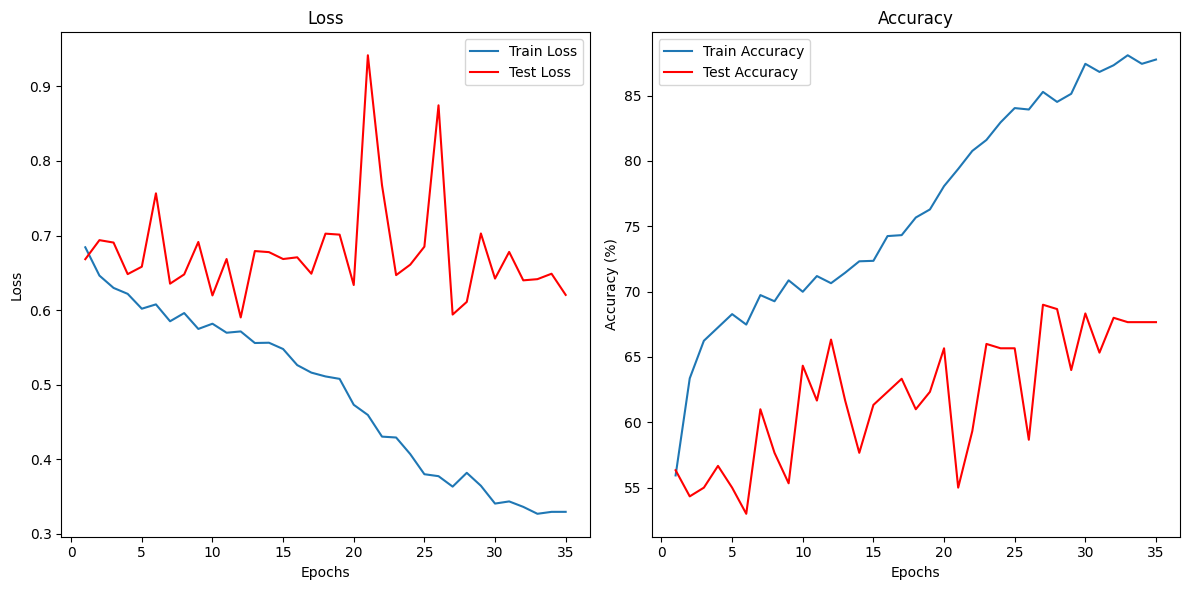

In [13]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss", color="r")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy", color="r")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
custom_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = custom_model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6767
Precision: 0.7494
Recall: 0.6767
F1 Score: 0.6512
